### UCI Wine Quality Dataset
- Wine Quality Dataset: https://archive.ics.uci.edu/ml/datasets/wine+quality
- 11 chemical properties of various red and white wines, along with a quality score ranging from 0-10.


### Import the libraries we'll need

In [1]:
# Import the libraries we'll use below.
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns  # for nicer plots
sns.set(style="darkgrid")  # default style

import tensorflow as tf
from tensorflow import keras
from keras import metrics

%matplotlib inline

### Wine Quality: Import and Visualize Data

In [2]:
wine_red = pd.read_csv('../datasets/winequality-red.csv', delimiter=';')
wine_white = pd.read_csv('../datasets/winequality-white.csv', delimiter=';')

wine_red['color'] = 'red'
wine_white['color'] = 'white'

wine = pd.concat([wine_red, wine_white], ignore_index=True)

In [3]:
#move quality column to the end!
col_to_move = wine.pop("quality")
wine.insert(12, "quality", col_to_move)

print(wine['color'].value_counts())
print('\n')
wine.head()

white    4898
red      1599
Name: color, dtype: int64




,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,red,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,red,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,red,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,red,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,red,5


In [4]:
# First, we get a list of indices corresponding to the rows.
indices = np.arange(wine.shape[0])
print('indices:', indices, '\n')

# Next, we shuffle the indices using np.random.permutation but set a random seed
# so that everyone gets the same results each time.
np.random.seed(0)
shuffled_indices = np.random.permutation(indices)
print('shuffled indices:', shuffled_indices, '\n')

# Finally, we use dataframe.reindex to change the ordering of the original
# dataframe.
wine = wine.reindex(shuffled_indices)
display(wine)

# Note that this could be done in one fancy line:
# car_data = car_data.reindex(np.random.permutation(car_data.shape[0]))

indices: [   0    1    2 ... 6494 6495 6496] 

shuffled indices: [5316 5210 3518 ... 1653 2607 2732] 



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,color,quality
5316,6.3,0.18,0.24,3.4,0.053,20.0,119.0,0.99373,3.11,0.52,9.2,white,6
5210,6.8,0.14,0.18,1.4,0.047,30.0,90.0,0.99164,3.27,0.54,11.2,white,6
3518,7.3,0.22,0.50,13.7,0.049,56.0,189.0,0.99940,3.24,0.66,9.0,white,6
1622,7.6,0.67,0.14,1.5,0.074,25.0,168.0,0.99370,3.05,0.51,9.3,white,5
2443,7.3,0.21,0.29,1.6,0.034,29.0,118.0,0.99170,3.30,0.50,11.0,white,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4931,6.5,0.22,0.28,3.7,0.059,29.0,151.0,0.99177,3.23,0.41,12.1,white,7
3264,6.5,0.13,0.37,1.0,0.036,48.0,114.0,0.99110,3.41,0.51,11.5,white,8
1653,6.8,0.20,0.59,0.9,0.147,38.0,132.0,0.99300,3.05,0.38,9.1,white,6
2607,6.6,0.22,0.37,1.2,0.059,45.0,199.0,0.99300,3.37,0.55,10.3,white,7


### Build Histogram and Describe NON-NORMALIZED datasets

In [5]:
print(list(wine.columns))

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol', 'color', 'quality']


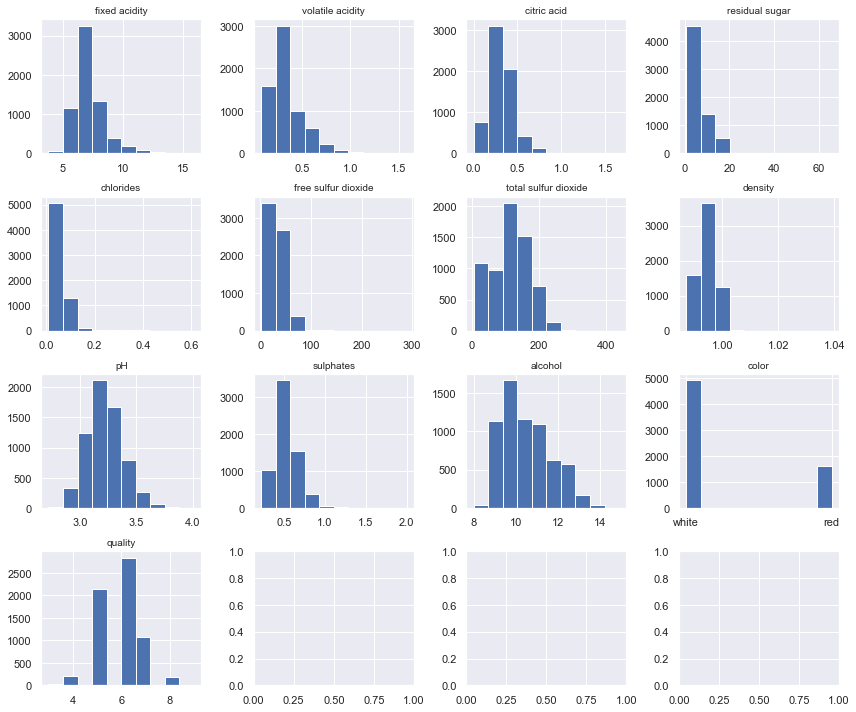

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000,6497.000000
mean,7.215307,0.339666,0.318633,5.443235,0.056034,30.525319,115.744574,0.994697,3.218501,0.531268,10.491801,5.818378
std,1.296434,0.164636,0.145318,4.757804,0.035034,17.749400,56.521855,0.002999,0.160787,0.148806,1.192712,0.873255
min,3.800000,0.080000,0.000000,0.600000,0.009000,1.000000,6.000000,0.987110,2.720000,0.220000,8.000000,3.000000
25%,6.400000,0.230000,0.250000,1.800000,0.038000,17.000000,77.000000,0.992340,3.110000,0.430000,9.500000,5.000000
50%,7.000000,0.290000,0.310000,3.000000,0.047000,29.000000,118.000000,0.994890,3.210000,0.510000,10.300000,6.000000
75%,7.700000,0.400000,0.390000,8.100000,0.065000,41.000000,156.000000,0.996990,3.320000,0.600000,11.300000,6.000000
max,15.900000,1.580000,1.660000,65.800000,0.611000,289.000000,440.000000,1.038980,4.010000,2.000000,14.900000,9.000000


In [6]:
# Create a 4 x 3 grid of histograms
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 10))

# Loop through each variable and plot its histogram
for i, ax in enumerate(axes.flatten()):
    # Ignore the last subplot if there are not enough variables
    if i >= len(wine.columns):
        break
    
    # Plot the histogram of the ith variable
    ax.hist(wine.iloc[:, i])
    ax.set_title(wine.columns[i], fontsize=10)

# Adjust the spacing between subplots and display the plot
fig.tight_layout()
plt.show()


display(wine.describe())

<AxesSubplot:>

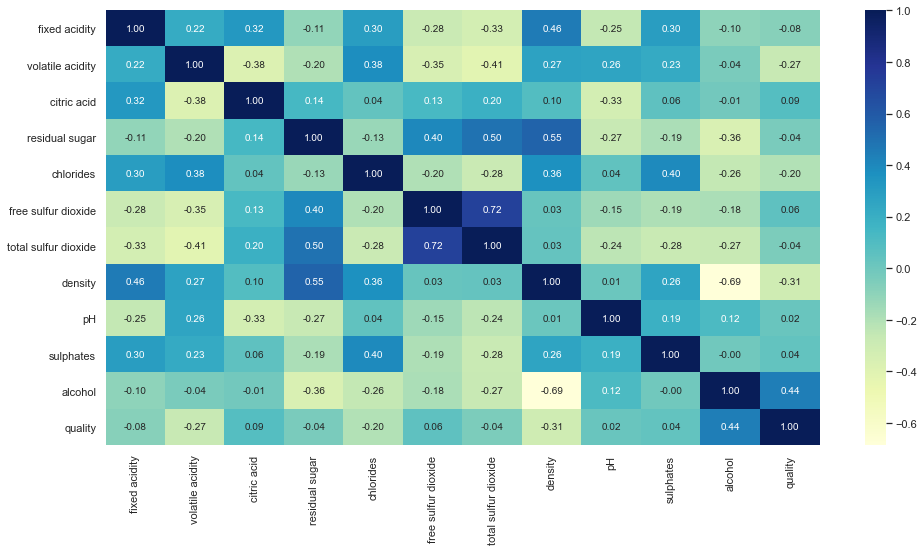

In [7]:
plt.figure(figsize= (16, 8))
sns.heatmap(wine.corr(), annot = True, cmap= 'YlGnBu', fmt= '.2f')

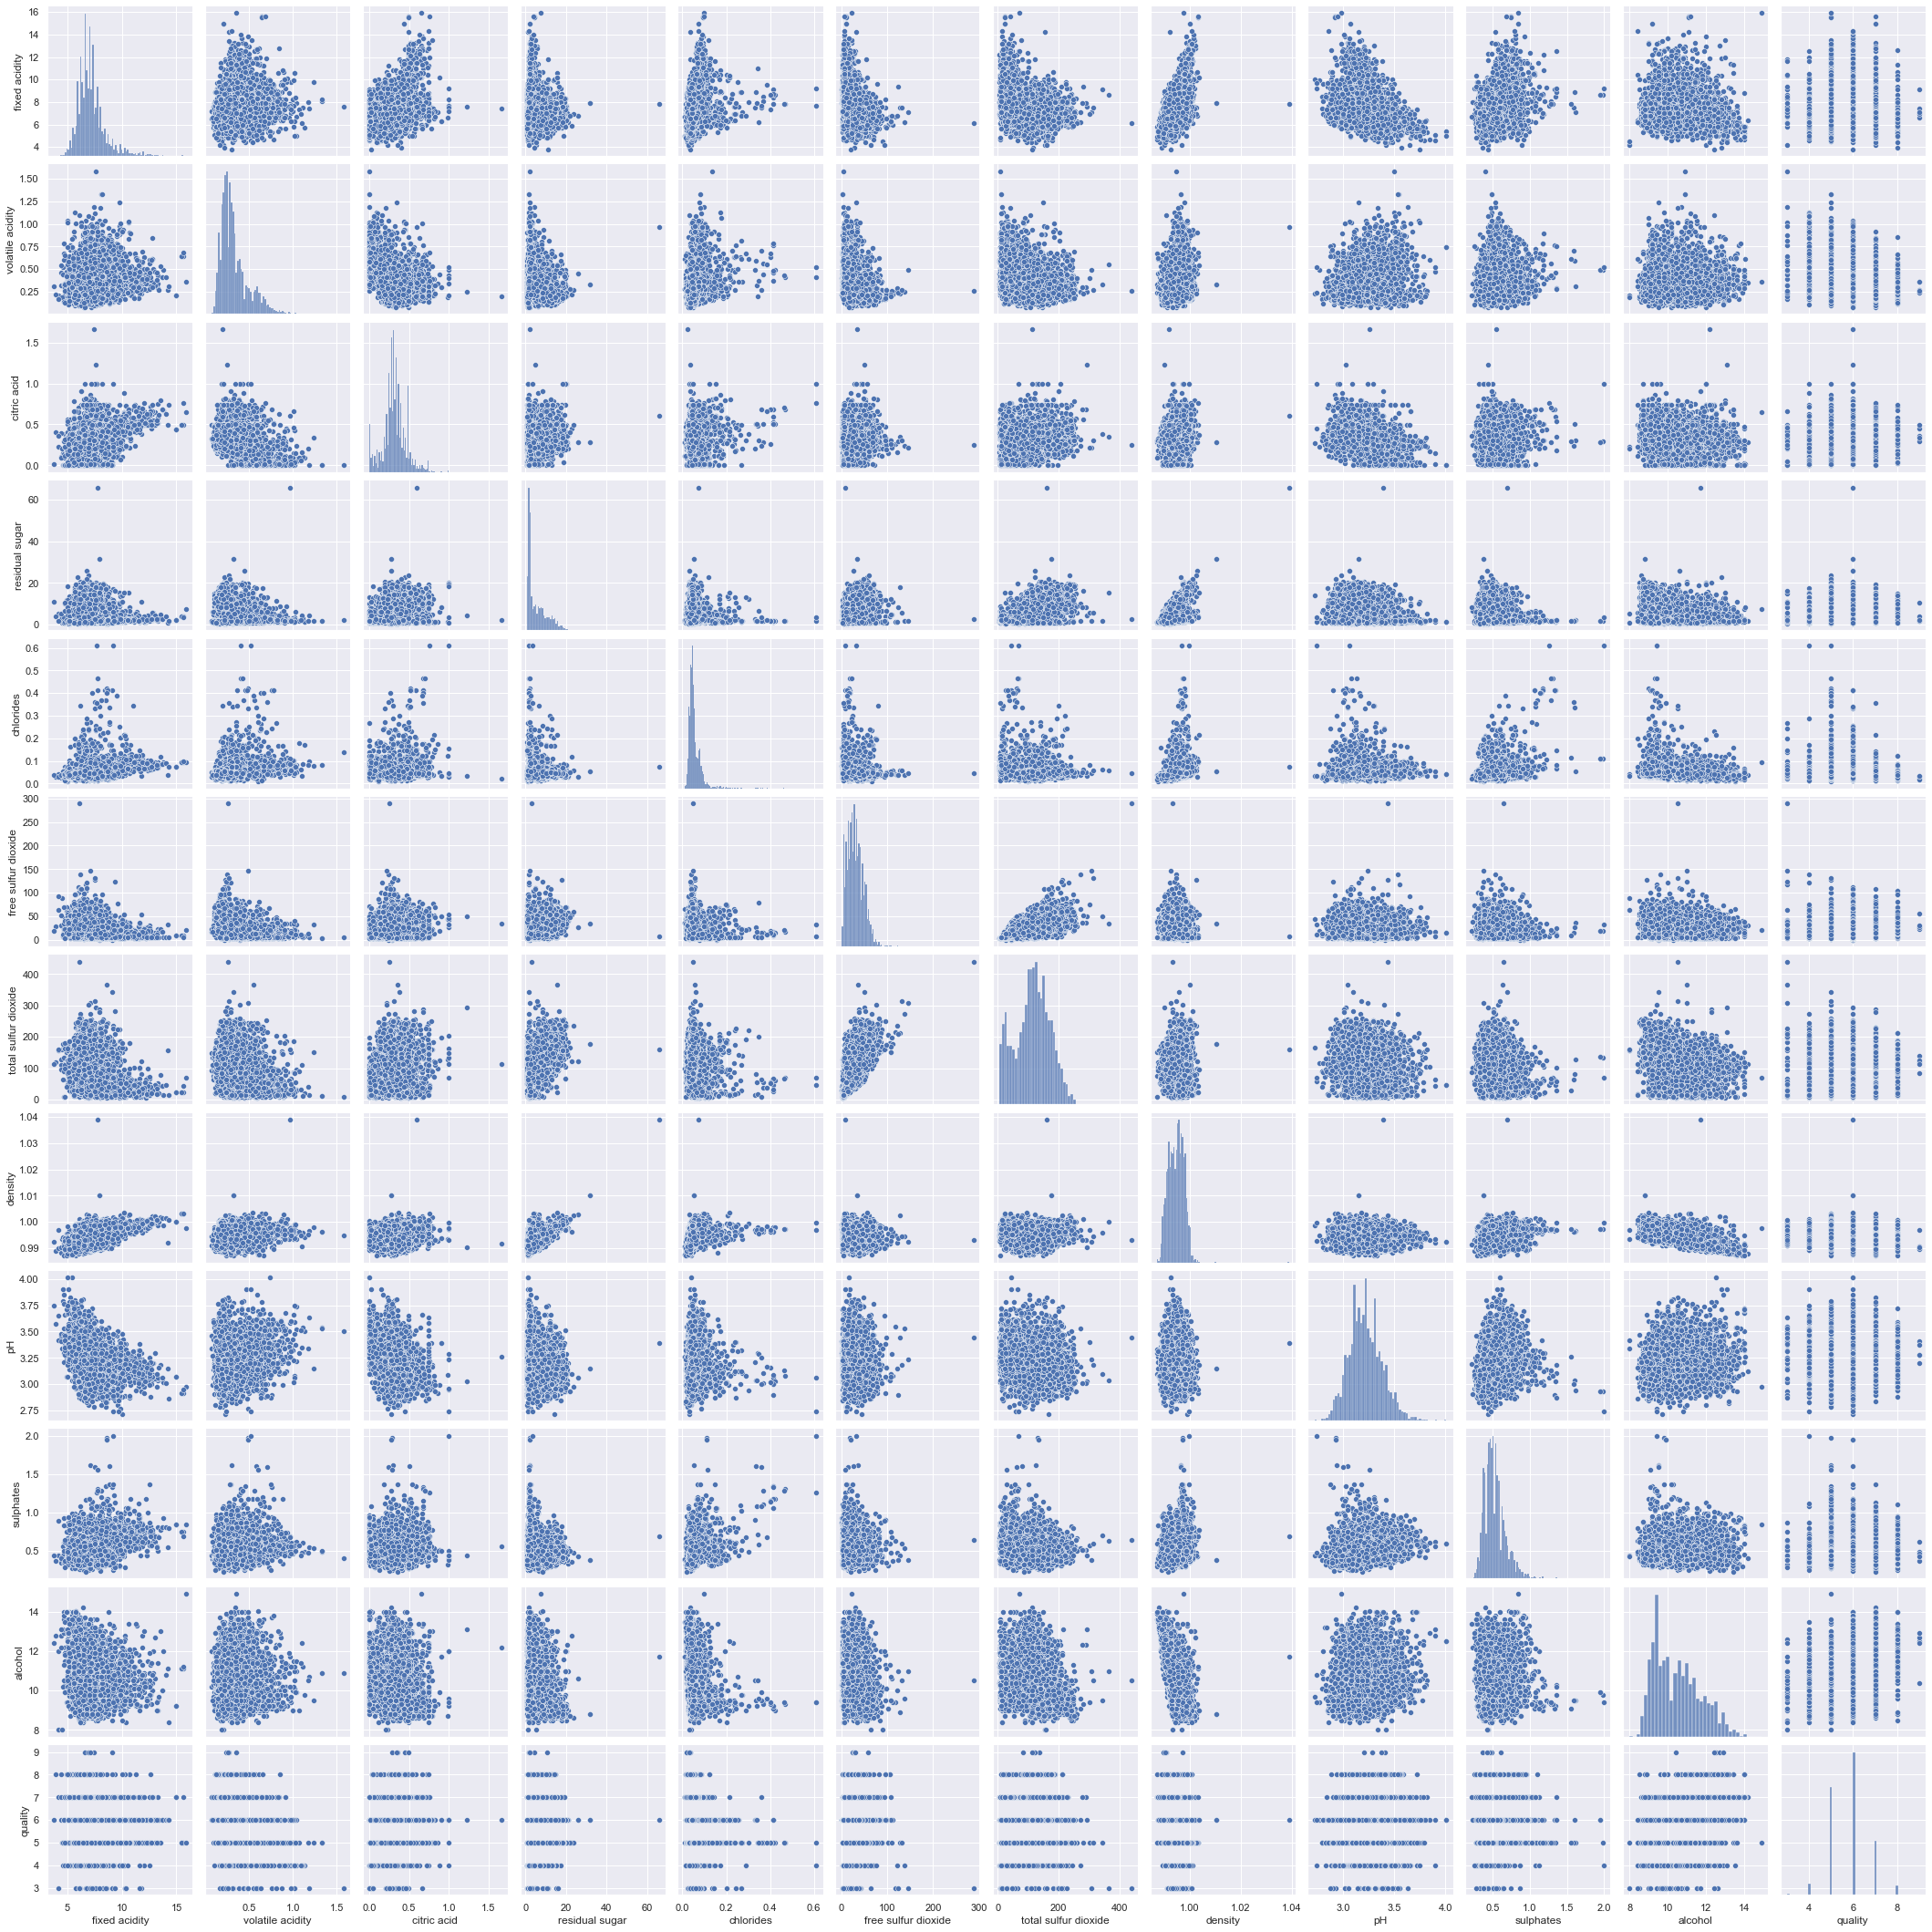

In [55]:
sns.pairplot(wine)